In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import os
import pandas as pd
import math
import seaborn as sns

from scipy.special import logsumexp
from pathlib import Path
from tqdm.auto import tqdm, trange

from bge_score_jax import BGe

/home/zj448/.conda/envs/jax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
dags_compressed = np.load('/data/zj448/exact_posteriors/dags_4.npy')

In [7]:
dags_compressed.shape

(543, 2)

In [8]:
def compute_exact_posterior(dags_compressed, observations, batch_size=1, verbose=True):
    num_variables = observations.shape[1]
    model = BGe(num_variables=num_variables)

    @jax.jit
    def log_prob(observations, adjacencies_compressed):
        adjacencies = jnp.unpackbits(adjacencies_compressed, axis=1, count=num_variables ** 2)
        adjacencies = adjacencies.reshape(-1, num_variables, num_variables)

        v_log_prob = jax.vmap(model.log_prob, in_axes=(None, 0))
        log_probs = v_log_prob(observations, adjacencies)
        return jnp.sum(log_probs, axis=1)

    num_dags = dags_compressed.shape[0]
    log_probs = np.zeros((num_dags,), dtype=np.float32)
    for i in trange(0, num_dags, batch_size, disable=(not verbose)):
        # Get a batch of (compressed) DAGs
        batch_compressed = dags_compressed[i:i + batch_size]

        # Compute the BGe scores
        log_probs[i:i + batch_size] = log_prob(observations, batch_compressed)

    # Normalize the log-marginal probabilities
    log_probs = log_probs - logsumexp(log_probs)
    return log_probs

In [9]:
def edge_log_marginal(dags_compressed, log_joint, num_variables, batch_size=1, verbose=True):
    @jax.jit
    def marginalize(log_probs, adjacencies_compressed):
        adjacencies = jnp.unpackbits(adjacencies_compressed, axis=1, count=num_variables ** 2)
        log_probs = jnp.where(adjacencies == 1, log_probs[:, None], -jnp.inf)
        return jax.nn.logsumexp(log_probs, axis=0)

    num_dags = dags_compressed.shape[0]
    log_marginal = []
    for i in trange(0, num_dags, batch_size, disable=(not verbose)):
        # Get a batch of data
        batch_compressed = dags_compressed[i:i + batch_size]
        log_probs = log_joint[i:i + batch_size]

        log_marginal.append(marginalize(log_probs, batch_compressed))

    log_marginal = np.stack(log_marginal, axis=0)
    log_marginal = logsumexp(log_marginal, axis=0)
    return log_marginal.reshape(num_variables, num_variables)

In [10]:
def get_transitive_closure(adjacency):
    # Warshall's algorithm
    def scan_fun(closure, i):
        outer_product = jnp.outer(closure[:, i], closure[i])
        return (jnp.logical_or(closure, outer_product), None)
    
    adjacency = adjacency.astype(jnp.bool_)
    arange = jnp.arange(adjacency.shape[0])
    closure, _ = jax.lax.scan(scan_fun, adjacency, arange)

    return closure

def path_log_marginal(dags_compressed, log_joint, num_variables, batch_size=1, verbose=True):
    @jax.jit
    def marginalize(log_probs, adjacencies_compressed):
        adjacencies = jnp.unpackbits(adjacencies_compressed, axis=1, count=num_variables ** 2)
        adjacencies = adjacencies.reshape(-1, num_variables, num_variables)
        closures = jax.vmap(get_transitive_closure)(adjacencies)
        log_probs = jnp.where(closures, log_probs[:, None, None], -jnp.inf)
        return jax.nn.logsumexp(log_probs, axis=0)

    num_dags = dags_compressed.shape[0]
    log_marginal = []
    for i in trange(0, num_dags, batch_size, disable=(not verbose)):
        # Get a batch of data
        batch_compressed = dags_compressed[i:i + batch_size]
        log_probs = log_joint[i:i + batch_size]

        log_marginal.append(marginalize(log_probs, batch_compressed))

    log_marginal = np.stack(log_marginal, axis=0)
    log_marginal = logsumexp(log_marginal, axis=0)
    return log_marginal.reshape(num_variables, num_variables)

## SAM

In [11]:
datasets = ['ell','spr','nofb']
dfs, observations = {}, {}

for dataset in datasets:
    dfs[dataset] = pd.read_csv(f'R_e_data/sam_{dataset}.csv')

    dfs[dataset] = dfs[dataset].apply(lambda col: ( col - col.mean() ) / col.std(), axis=0)  # Standardize data
    observations[dataset] = np.asarray(dfs[dataset])

In [13]:
root = Path('/data/zj448/exact_posteriors')

log_edge_marginals = {}
for dataset in datasets:
    log_joint = compute_exact_posterior(dags_compressed, observations[dataset], batch_size=2048)
    log_edge_marginals[dataset] = edge_log_marginal(dags_compressed,
        log_joint, observations[dataset].shape[1], batch_size=4096)

    with open(root / f'log_joint_{dataset}_sam.npy', 'wb') as f:
        np.save(f, log_joint)

    with open(root / f'log_edge_marginal_{dataset}_sam.npy', 'wb') as f:
        np.save(f, log_edge_marginals[dataset])

100%|██████████| 1/1 [00:00<00:00, 22.78it/s]


In [14]:
#root = Path('/data/zj448/exact_posteriors')

log_path_marginals = {}
for dataset in datasets:
    log_joint = np.load(root / f'log_joint_{dataset}_sam.npy')
    log_path_marginals[dataset] = path_log_marginal(dags_compressed,
        log_joint, observations[dataset].shape[1], batch_size=1024)

    with open(root / f'log_path_marginal_{dataset}_sam.npy', 'wb') as f:
        np.save(f, log_path_marginals[dataset])

100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


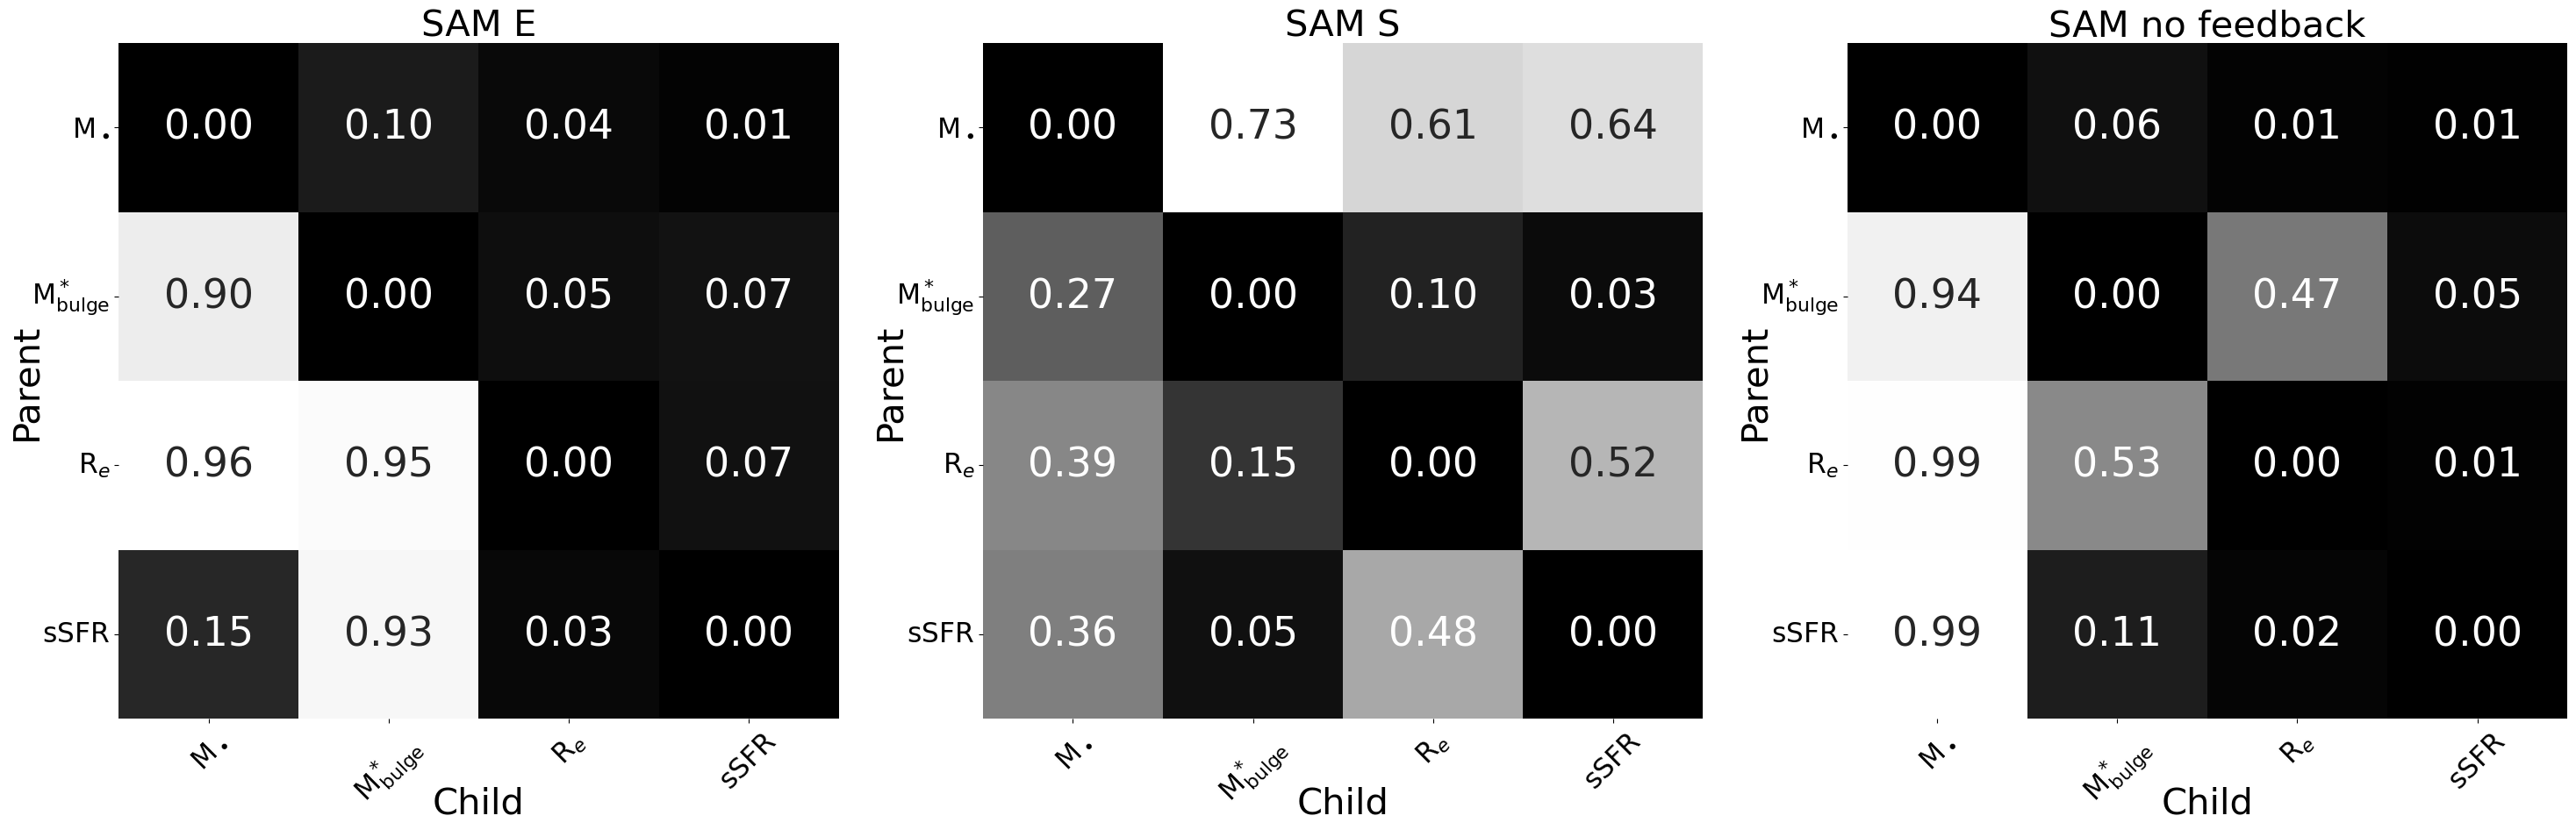

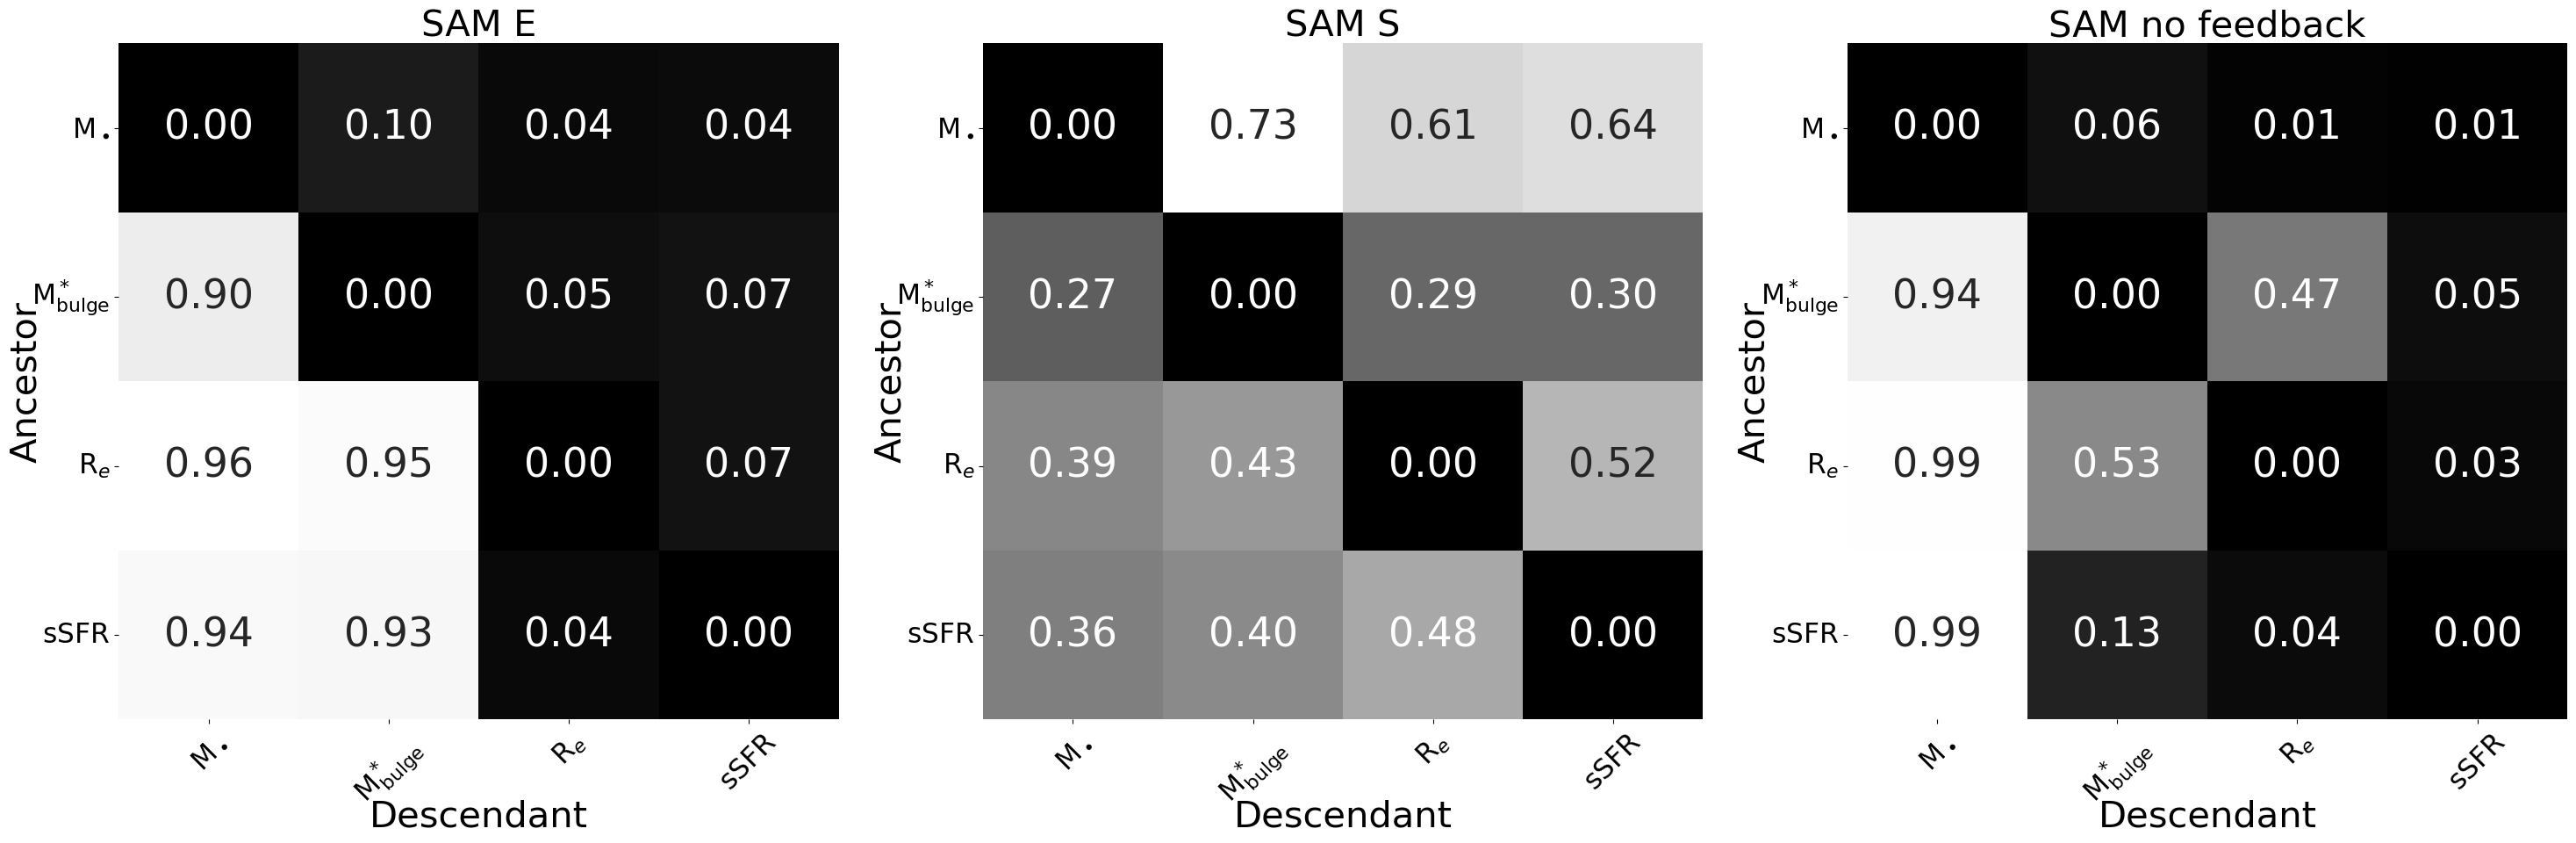

In [15]:
#root = Path('/data/zj448/exact_posteriors')

plt.figure(figsize=(36, 10))

labels_list = [r'$\text{M}_\bullet$',r'$\text{M}_\text{bulge}^*$', r'$\text{R}_e$', r'$\text{sSFR}$']
typename = {'ell':'SAM E','spr':'SAM S','nofb':'SAM no feedback'}
fontscale=1.5
cmap='gray'

for i, dataset in enumerate(datasets):
    ax = plt.subplot2grid((1, 3), (0, i))
    log_edge_marginal = np.load(root / f'log_edge_marginal_{dataset}_sam.npy')
    marginal = np.exp(log_edge_marginal)

    sns.heatmap(marginal, cmap=cmap, ax=ax,
              annot=marginal, annot_kws={"fontsize":22*fontscale}, fmt='.2f', cbar=False)
    
    ax.set_title(typename[dataset],fontsize=20*fontscale)
    ax.set_xticklabels(labels_list,rotation=45,fontsize=15*fontscale)
    ax.set_yticklabels(labels_list,rotation=0,fontsize=15*fontscale)
    ax.set_xlabel('Child',labelpad=-20,fontsize=20*fontscale)
    ax.set_ylabel('Parent',labelpad=-10,fontsize=20*fontscale)
#plt.savefig('figures/edge_marginals.png', dpi=300)
plt.show()

plt.figure(figsize=(36, 10))
for i, dataset in enumerate(datasets):
       ax = plt.subplot2grid((1, 3), (0, i))
       log_path_marginal = np.load(root / f'log_path_marginal_{dataset}_sam.npy')
       marginal = np.exp(log_path_marginal)

       sns.heatmap(marginal, cmap=cmap, ax=ax,
              annot=marginal, annot_kws={"fontsize":22*fontscale}, fmt='.2f', cbar=False)
       
       ax.set_title(typename[dataset],fontsize=20*fontscale)
       ax.set_xticklabels(labels_list,rotation=45,fontsize=15*fontscale)
       ax.set_yticklabels(labels_list,rotation=0,fontsize=15*fontscale)
       ax.set_xlabel('Descendant',labelpad=-10,fontsize=20*fontscale)
       ax.set_ylabel('Ancestor',labelpad=-10,fontsize=20*fontscale)
       #plt.savefig('figures/edge_marginals.png', dpi=300)
plt.show()

In [16]:
df_sam_ell = pd.read_csv(f'R_e_data/sam_ell.csv')
df_sam_spr = pd.read_csv(f'R_e_data/sam_spr.csv')
df_sam_nofb = pd.read_csv(f'R_e_data/sam_nofb.csv')

In [17]:
len(df_sam_ell),len(df_sam_spr),len(df_sam_nofb)

(1189, 1999, 2663)